# Lecture 2

[kaggle House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)에서 가져온 데이터를 이용하여, Linear Regression을 구현해보자.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
train = pd.read_csv('./files/train.csv')
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

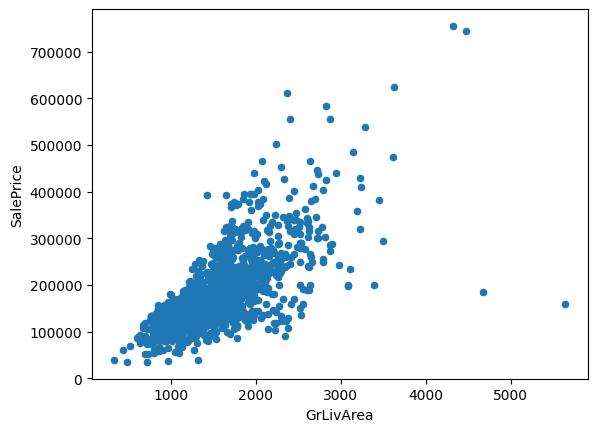

In [23]:
train[['SalePrice','GrLivArea']].plot.scatter(x='GrLivArea', y='SalePrice')

우리의 SalesPrice가 구하기를 원하는 y이고 이것은 연속적인(continuous)한 value이기 때문에 linear regression을 사용하는 과제라고 볼 수 있다. GriLivArea(Above grade(ground) living area square feet)은 cs229에서 말하는 size(feet^2)와 가장 유사한 column이라고 생각되어서 뽑았다. 단순하게 scatter plot을 해봐도 사이드로 많이 빠진 몇 outlier들을 제외하면 어느 정도의 linear 관계를 볼 수 있을 거라고 생각된다.

## Hypothsis function

hypothesis란 input(feature, x)와 output(targer,label, y)의 관계를 나타내는 함수를 말한다. input은 많이 고려할수록 더 유의미한 가설을 뽑아낼 확률이 높아지겠지만, 그에 따라 지수적으로 연산량이 늘어나며 사실상 그렇게 할 수 없다. 따라서 유의미해 보이는 feature를 selection하고 그것을 가지고 가설을 세워야 한다. 우선은 한 개의 종속변수(x:GrivLivArea)와 한 개의 독립변수(y:SalePrice)를 가지고 linear 선형 함수로 가설을 세워보자.

옆에 보이는 것이 수식 정의에 필요한 수학적 기호의 정의들이다.
````{margin}
```{glossary}
$m$
    number of training examples   

$n$
    number of features   

$x$
    input variable / features   

$y$
    output variable / target variable   

$(x,y)$
    one training example   

$(x^{i},y^{i})$
    $i$-th trainig example   
    
${\theta}_i$
    parameters   
```
````

$$
h_{\theta}(x) = \theta_{0} + \theta_{1}x
$$

우리는 주어진 데이터로 $h_{\theta}$와 실제 가지고 있는 target값인 $y$의 차이 즉 `$error = h_{\theta}(x) - y$`가 가장 작은 $\theta_{0}$와 $\theta_{1}$을 찾고 싶을 것이다. 이 error 즉 잔차라고도 하고 cost 비용이라고도 하는 것을 최소화하는 함수를 cost function이라고 한다.

## Cost function

위에서 보았듯이 우리는 가설함수 $h_{\theta}(x)$와 실제값 y와의 비용(잔차 error loss)를 최소화하는 방법으로 머신을 학습시키는 것이 목표이다. 살짝 정리해보면 선형회귀는 우리의 learning algorithm이고 이제 나올 cost function은 우리가 최소화하고자 하는 함수이다. 결국 이 cost function을 최소화하는 것이 learning algorithm의 성능을 높이는 것이라고 볼 수 있다.

우리가 사용할 cost function은 MSE(least squared error)이다. 

$$
J(\theta) = \frac{1}{2m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})^2 = \frac{1}{2m}\sum_{i=1}^{m}(\theta_{0} + \theta_{1}x^{(i)} - y^{(i)})^2
$$

````{margin}
```{admonition}왜 m이 아니라 2m인가?   
평균이라면 {$m$} 데이터의 갯수대로 나눠줘야하는게 아닌가 하는 의문이 들 수 있는데, 그것은
```
````

## Sklearn linear regression

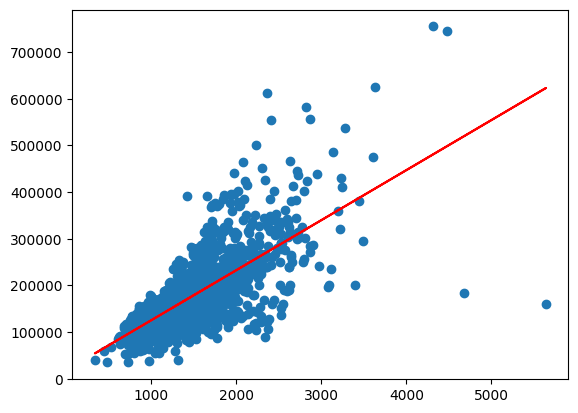

$h(\Theta)$= 107.13x + 18569.03


In [43]:
X = train['GrLivArea'].values.reshape(-1,1)
y = train['SalePrice'].values.reshape(-1,1)
lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.show()

print("$h(\Theta)$" f"= {lr.coef_[0][0]:.2f}x + {lr.intercept_[0]:.2f}")